# MSCA 31008 Data Mining Principles: Final Project

## Developing Depression Risk Prediction Models with the National Health and Nutrition Examination Survey Data 2013-2014

### Group 2: Amro Hassan, Kat Hutcheson, Bei Wang, Fangyuan Zhao

## 1. Introduction

According to WHO, depression has become one of the leading causes of disability worldwide (Santomauro et al., 2020). In the United States, it is also estimated that almost ten million people suffer from depression, while only one-third of them received appropriate treatment (Bailey et al., 2019). Moreover, as the COVID-19 pandemic continues to threat people's mental wellbeing, the burden of major depressive disorder is expected to grow (Santomauro et al., 2020). 

Meanwhile, the risk factors of depression are multifactoral, including genetics, lifestyle, socioeconomic status, environmental stressors, and other structural factors (Bailey et al., 2019). This makes machine learning techniques extremely helpful in developing a comprehensive depression risk prediction model. With such a model, companies in the healthcare industry can better target people with higher risks of depression, and provide self-testing resources and counseling service to them.   

In this regards, the National Health and Nutrition Examination Survey (NHANES) is a great dataset to work on as it contains a rich sample of many critical demographic, socioeconomic and behavioral risk factors as well as measures of depression. In fact, a model with similar intent has been built using the NHANES dataset previously (Oh et al., 2019). However, this model does not take into account the reality that people of different racial/ethnic backgrounds can have very different experiences and stressors in life, which means different risk factors of depression (Bailey et al., 2019). This means that having only one model without including race/ethnicity as a variable might not be a good solution. Fortunately, the NHANES dataset is also multiethnic by design. Therefore, the first objective of our study is to see whether different racial/ethnic populations should use different depression risk prediction models, and if so, build these models accordingly. 

Another aim of the study is to use only variables that can be easily measured to build the model. This is because the existing model contains many biomarker variables (e.g. blood pressure, Creatinine level in urine, cadmium and Glycohemoglobin level in blood, FVC) that needs to be collected physically. This makes implementation of the current model for business use very difficult and expensive. Therefore, we would like to build the model(s) using only variables that are collected through questionnaire in NHANES. The performance of the risk prediction model(s) will be measured by metrics including overall accuracy, specificity and sensitivity. The existing risk prediction model that used serial datasets from 1999 to 2012 and all available variables had an AUC of 0.92. Thus, an acceptable performance of our model should be at least 0.85.

## 2. Dataset description

The dataset we will be using is the National Health and Nutrition Examination Survey (NHANES, 2013-2014). The NHANES survey is conducted by the Centers for Disease Control and Prevention (CDC) along with the National Center for Health Statistics (NCHS), aiming at providing information on the prevalence of multiple diseases as well as associated risk factors. The survey collected data through survey interviews as well as physical examinations. Starting from 2011, the study intentionally oversampled non-Hispanic Asians, in addition to the ongoing oversample of Hispanics and non-Hispanic blacks, forming a very diverse dataset.

In the data, depression is measured using Patient Health Questionnaire (PHQ-9). PHQ-9 comprises five categories, where a cut-off point of 0–4 indicates no depressive symptoms, 5–9 mild depressive symptoms, 10–14 moderate depressive symptoms, 15–19 moderately-severe depressive symptoms, and 20–27 severe depressive symptoms.

## 3. Prepare and explore the data

###  3.1 Data preparation

In [1]:
import sklearn 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
from functools import reduce
import os
from dmba import classificationSummary
%matplotlib inline

no display found. Using non-interactive Agg backend


In [3]:
#not including medications or labs because they are hard to collect in reality
os.chdir('/Users/beiw/Google Drive/PHS@UChicago/2021 Autumn/data mining/project/Depression-risk-main/data')
files= ['demographic.csv', 'diet.csv', 'questionnaire.csv'] 
demo= pd.read_csv('demographic.csv')
diet= pd.read_csv('diet.csv')
exam= pd.read_csv('examination.csv')
lab= pd.read_csv('labs.csv')
med= pd.read_csv('medications.csv')
qr= pd.read_csv('questionnaire.csv')

In [4]:
print('demo', demo.shape)
print('diet', diet.shape)
print('exam', exam.shape)
print('lab', lab.shape)
print('med', med.shape)
print('ques', qr.shape)

demo (10175, 47)
diet (9813, 168)
exam (9813, 224)
lab (9813, 424)
med (20194, 13)
ques (10175, 953)


In [8]:
ls=[]
for file in files: 
    df= pd.read_csv(file)
    ls.append(df)
df_merge= reduce(lambda x,y: pd.merge(x, y,  how='inner', on= 'SEQN', suffixes=('', '_drop')), ls)
df_merge.drop([col for col in df_merge.columns if 'drop' in col], axis=1, inplace=True)
print("merged df shape:", df_merge.shape)

merged df shape: (9813, 1166)


In [9]:
#check for duplicated SEQN
df_merge.SEQN.duplicated().value_counts()

False    9813
Name: SEQN, dtype: int64

In [10]:
#Get codebook for the dataset: for meaning of features
#This was done in a seperate files; 
#some of the variables names are inconsistent, resulting in NaN, so changed them manually.
cbook= pd.read_csv('nhanes_2013_2014_codebook.csv')

### 3.2 Missing data cleaning
Missing data in the dataset are all represented in 7s and 9s. We drop observations that have missing data in the target variable (phq9), which results in 3657 unique observations. Among the rest of the features, we drop those with more than 20% missing data or those are non-numeric, which results in 502 features. Within the dataset that has minimized missingness, we further prepare the data set by imputing the rest of the missingness using the most_frequent method in each column. 

In [11]:
#replace all 7s and 9s as null 
df_merge.replace({7:None, 9:None, 77:None,99:None,777:None,999:None,7777:None,9999:None,77777:None,99999:None,
            777777:None,999999:None,55:None,555:None,5555:None,8:None,88:None}, inplace=True)

#### Drop observations with missingness in target feature
The target feature is PHQ9, which consists of 10 features from DPQ010 to DPQ100.

In [12]:
#test
df_merge.DPQ050.describe

<bound method NDFrame.describe of 0       0.0
1       0.0
2       0.0
3       NaN
4       3.0
       ... 
9808    0.0
9809    NaN
9810    NaN
9811    NaN
9812    NaN
Name: DPQ050, Length: 9813, dtype: float64>

In [13]:
#create phq9 scores and drop rows with any item missing 
df_merge['phq9']= df_merge[['DPQ010','DPQ020','DPQ030','DPQ040', 'DPQ050', 'DPQ060', 'DPQ070', 'DPQ080', 'DPQ090', 'DPQ100']].sum(axis=1, skipna=False)
df_merge= df_merge[df_merge['phq9'].notna()]
print(df_merge.shape)

(3657, 1167)


In [14]:
df_merge.phq9.describe()

count    3657.000000
mean        5.202625
std         4.997506
min         1.000000
25%         2.000000
50%         3.000000
75%         7.000000
max        30.000000
Name: phq9, dtype: float64

#### Drop feature columns with more than 20% missing data 

In [15]:
#drop columns with more than no missing data
df_merge= df_merge.dropna(thresh= 0.8*len(df_merge), axis=1)

#### Drop non-numeric columns

In [16]:
# exclude non-numeric values
df_merge = df_merge.select_dtypes(['number'])
print(len(df_merge.columns), 'columns left')

292 columns left


In [17]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3657 entries, 0 to 9805
Columns: 292 entries, SEQN to phq9
dtypes: float64(279), int64(13)
memory usage: 8.2 MB


#### Impute missing values 

In [18]:
#imputation 
from sklearn.impute import SimpleImputer
imp_mode=SimpleImputer(strategy='most_frequent')

df_merge = pd.DataFrame(imp_mode.fit_transform(df_merge), columns=df_merge.columns)
#could try other imputation method KNN

### 3.3 Variable Selection
Since we want to build model(s) that uses only variables that can be measured easily, we will first do some initial selection of the variables.

In [19]:
#go over the dictionary manually and drop the unwanted variables
col = df_merge.columns
df_col = cbook[cbook['variable'].isin(col)]
df_col.to_csv(r'df_col.csv') #done in excel

In [20]:
#remove variables that are related to administration/operation (e.g. language of interview, interpreter code)
admin = pd.read_csv('administrative_col.csv')
admin_col = admin.columns
df_merge = df_merge.drop(admin.columns, 1)

In [21]:
#remove variables that are collected and calculated after very detailed Dietary Interviews
#(e.g. total dietary fiber)
#Can keep variables that can be easily answered
#(e.g. Total bottled water drank yesterday)
dietary = pd.read_csv('diet_col.csv')
diet_col = dietary.columns
df_merge = df_merge.drop(dietary.columns, 1)

In [22]:
# remove one of HUQ010 and HSD010 (identical question asked in different surveys, highly correlated)
df_merge = df_merge.drop('HUQ010', 1)

In [23]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3657 entries, 0 to 3656
Columns: 212 entries, SEQN to phq9
dtypes: float64(212)
memory usage: 5.9 MB


In [24]:
df_merge.to_csv(r'df_merge.csv')

In [26]:
df_merge.shape

(3657, 212)

Now, after cleaning, only 212 columns left

### 3.4 Target features (PHQ9) visualization

The target feature was looked at in a few different ways: 

#### PHQ9 itself is a numeric feature with a possible range from 0 to 30

#### PHQ9 was dichotomized in the follow ways according to exisitng literature  

* Mild depression: phq9>=5

* Moderate depression: phq9>=15  

* Severe depression: phq9>=20 

#### Suicidal ideation was added as a potential target

* Suicidal ideation: DPQ090 >0


#### Numeric PHQ9 

(array([1866.,  800.,  411.,  236.,  135.,   93.,   63.,   32.,   16.,
           5.]),
 array([ 1. ,  3.9,  6.8,  9.7, 12.6, 15.5, 18.4, 21.3, 24.2, 27.1, 30. ]),
 <BarContainer object of 10 artists>)

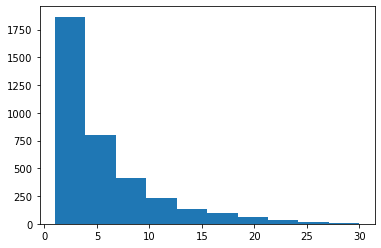

In [25]:
plt.hist(df_merge.phq9)

#### Mild depression

In [27]:
df_merge['mild_dep']= np.where(df_merge['phq9']>=5,1,0)
print('mild', df_merge['mild_dep'].value_counts())

mild 0    2228
1    1429
Name: mild_dep, dtype: int64


(array([2228.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1429.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

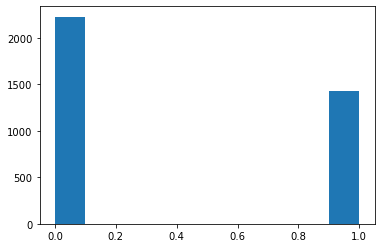

In [28]:
plt.hist(df_merge.mild_dep)

#### Moderate depression

In [29]:
df_merge['mod_dep']= np.where(df_merge['phq9']>=15,1,0)
print('modereate', df_merge['mod_dep'].value_counts())

modereate 0    3402
1     255
Name: mod_dep, dtype: int64


(array([3402.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         255.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

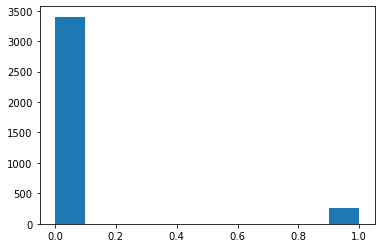

In [30]:
plt.hist(df_merge.mod_dep)

#### Severe depression

In [31]:
df_merge['sev_dep']= np.where(df_merge['phq9']>=20,1,0)
print('severe', df_merge['sev_dep'].value_counts())

severe 0    3564
1      93
Name: sev_dep, dtype: int64


(array([3564.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          93.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

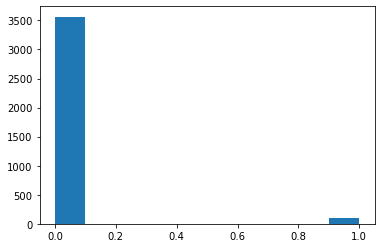

In [32]:
plt.hist(df_merge.sev_dep)

#### Suicidal ideation

In [33]:
df_merge['suicidal']= np.where(df_merge['DPQ090']>0,1,0)
print('suicidal', df_merge['suicidal'].value_counts())

suicidal 0    3474
1     183
Name: suicidal, dtype: int64


(array([3474.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         183.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

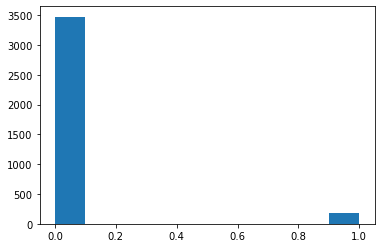

In [34]:
plt.hist(df_merge.suicidal)

## 3.4 Other key features exploration
We explored other key demographic features to describe this population. 

* A large proportion of the population is non-Hispanic white while there are also Hispanics, non-Hispanic blacks, and non-Hispanic Asians. 

* People's age ranges from 18 to 80 with larger proportions of the youngest and the oldest group. 

* There are more females than males. This population is also highly educated. About a quarter of the population was not US-born. 

*note: could some visualization of depression outcomes by these features*

### Race and ethnicity 
1(Mexican American), 2(Other Hispanic); 3(non-H white); 4(non-H black); 6(non-H Asian)

https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/DEMO_H.htm


(array([ 489.,    0.,  333.,    0., 1772.,    0.,  712.,    0.,    0.,
         351.]),
 array([1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ]),
 <BarContainer object of 10 artists>)

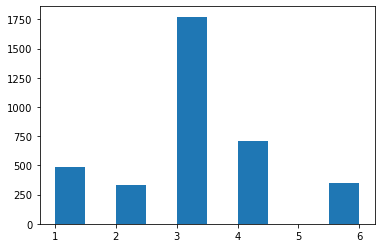

In [36]:
plt.hist(df_merge.RIDRETH3)

### Age

(array([569., 336., 346., 349., 328., 318., 355., 373., 264., 419.]),
 array([18. , 24.2, 30.4, 36.6, 42.8, 49. , 55.2, 61.4, 67.6, 73.8, 80. ]),
 <BarContainer object of 10 artists>)

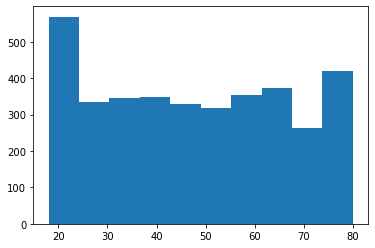

In [37]:
plt.hist(df_merge.RIDAGEYR)

In [38]:
df_merge.RIDAGEYR.describe()

count    3657.000000
mean       47.581624
std        19.245747
min        18.000000
25%        31.000000
50%        47.000000
75%        64.000000
max        80.000000
Name: RIDAGEYR, dtype: float64

### Gender (1: male; 2: female)

(array([1582.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        2075.]),
 array([1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ]),
 <BarContainer object of 10 artists>)

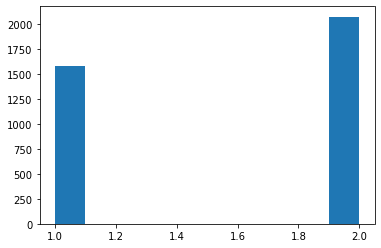

In [39]:
plt.hist(df_merge.RIAGENDR)

### Education attainment 
1(less than high school); 2(some high school); 3(high school graduate/GED or equivalent); 4(some college or AA degree); 5(college graduate or above)

(array([ 225.,    0.,  478.,    0.,    0.,  807.,    0., 1335.,    0.,
         812.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

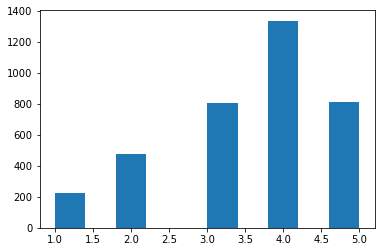

In [40]:
plt.hist(df_merge.DMDEDUC2)

### Country of birth (1: born in the US; 2: not born in the US)

(array([2749.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         908.]),
 array([1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ]),
 <BarContainer object of 10 artists>)

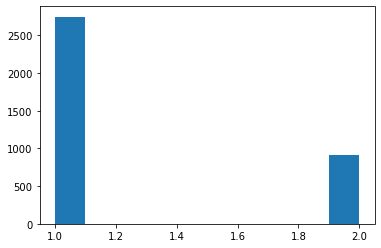

In [41]:
plt.hist(df_merge.DMDBORN4)

## 3.5 Feature selection (feature importance)

### Create a function for normalize data 

In [42]:
from sklearn.preprocessing import StandardScaler 
def normalize_data(X): 
    X_std= pd.DataFrame(StandardScaler().fit_transform(X))
    X_std.columns= X.columns
    return X_std

### Linear regression using phq9 as a numeric target

Coefficients of regressions can be used directly as some crude type of feature importance score. So I'm starting with regression models and use their coefficients for insights on feature selection.

This is an overfitting and naiive model that I use to get some sense of the top ranked coefficients for feature selection.

In [43]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
#partition into X and y
target=['phq9']
drop_features= ['phq9',
                'SEQN',
                'DPQ010', 'DPQ020', 'DPQ030', 'DPQ040', 'DPQ050', 'DPQ060','DPQ070','DPQ080', 'DPQ090', 'DPQ100',
               'mild_dep', 'mod_dep', 'sev_dep', 'suicidal']
X = df_merge[df_merge.columns.drop(drop_features)]
y= df_merge[target]
X_scaled= normalize_data(X)
y_scaled= normalize_data(y)
# #normalize data
# X_scaled= normalize_data(X)
# y_scaled= normalize_data(y)
# #training and validation sets split based on normalized data
train_X, valid_X, train_y, valid_y = train_test_split(X_scaled, y_scaled, test_size=0.4, random_state=42)
print('Training_X: ', train_X.shape)
print('Validation_X: ', valid_X.shape)
print('Training_y: ', train_y.shape)
print('Validation_y: ', valid_y.shape)
lr=LinearRegression()
lr.fit(train_X, train_y)

Training_X:  (2194, 200)
Validation_X:  (1463, 200)
Training_y:  (2194, 1)
Validation_y:  (1463, 1)


LinearRegression()

In [44]:
importance= lr.coef_
importance= importance.flatten()
columns= df_merge.columns
df = pd.DataFrame({'feature': train_X.columns, 'importance': importance})
df = df.sort_values('importance', ascending=False)

In [45]:
#select top 30 features 
df30= df[:30]
df30.columns=['variable', 'importance']
df30['variable'] = df30['variable'].apply(lambda x: x.upper())
df30 = pd.merge(left=df30, right=cbook, left_on='variable', right_on='variable', how='left')

<ipython-input-45-d343ccd9b52f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df30['variable'] = df30['variable'].apply(lambda x: x.upper())


In [46]:
df30

,variable,importance,label
0,DRABF,3.388439e+11,Breast-fed infant (either day)
1,HSAQUEX,7.690430e+10,Source of Health Status Data
2,RIDSTATR,1.459828e+05,Interview/Examination status
3,DR1.320Z,1.889268e+00,NaN
4,WTINT2YR,5.060547e-01,Full sample 2 year interview weight
5,HSD010,1.753291e-01,General health condition
6,SMDANY,1.204273e-01,Used any tobacco product last 5 days?
7,RIDRETH1,1.112498e-01,Race/Hispanic origin
8,RIAGENDR,1.067921e-01,Gender
9,HIQ011,7.578373e-02,Covered by health insurance


### Logistic regression: moderate depression
This is an overfitting and naiive model that I use to get some sense of the top ranked coefficients for feature selection.

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from matplotlib import pyplot
#partition into X and y
target=['mod_dep']
drop_features= ['phq9',
                'SEQN',
                'DPQ010', 'DPQ020', 'DPQ030', 'DPQ040', 'DPQ050', 'DPQ060','DPQ070','DPQ080', 'DPQ090', 'DPQ100',
               'mild_dep', 'sev_dep', 'suicidal', 'mod_dep']
X = df_merge[df_merge.columns.drop(drop_features)]
y= df_merge[target]
X_scaled= normalize_data(X)
# training and validation sets split, predictors are scaled
train_X, valid_X, train_y, valid_y = train_test_split(X_scaled, y, test_size=0.4, random_state=42, stratify=y)
print('Training_X: ', train_X.shape)
print('Validation_X: ', valid_X.shape)
print('Training_y: ', train_y.shape)
print('Validation_y: ', valid_y.shape)

#fit the model 
logit=LogisticRegression()
logit.fit(train_X, train_y)

Training_X:  (2194, 200)
Validation_X:  (1463, 200)
Training_y:  (2194, 1)
Validation_y:  (1463, 1)


/Users/beiw/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/beiw/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [48]:
importance= logit.coef_
importance= importance.flatten()
columns= df_merge.columns
df = pd.DataFrame({'feature': train_X.columns, 'importance': importance})
df = df.sort_values('importance', ascending=False)

In [49]:
#select top 30 features 
df30= df[:30]
df30.columns=['variable', 'importance']
df30['variable'] = df30['variable'].apply(lambda x: x.upper())
df30 = pd.merge(left=df30, right=cbook, left_on='variable', right_on='variable', how='left')

<ipython-input-49-d343ccd9b52f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df30['variable'] = df30['variable'].apply(lambda x: x.upper())


In [50]:
df30

,variable,importance,label
0,HSD010,0.917464,General health condition
1,PFQ054,0.461042,Need special equipment to walk
2,FSDAD,0.457527,Adult food security category
3,MCQ082,0.433019,Ever been told you have celiac disease?
4,CBD120,0.420447,Money spent on eating out
5,HEQ030,0.395274,Ever told you have Hepatitis C?
6,CBQ545,0.360942,Would use fast food nutrition info
7,FSD032A,0.354912,HH Worried run out of food
8,DR1.320Z,0.347366,NaN
9,MCQ160B,0.296165,Ever told had congestive heart failure


#### Performance in the test set
The accuracy of the overfitting model is not bad as expected. The actual and predicted 1 are unreasonably small. This might be because of the imbalanced dataset we have. So we will need to balance the sample with sampling techniques. 

In [51]:
classificationSummary(valid_y, logit.predict(valid_X))

Confusion Matrix (Accuracy 0.9146)

       Prediction
Actual    0    1
     0 1320   41
     1   84   18


### note: 
*we could replicate this on suicidal ideation*

*we need to balance sampling at some point*

*we could rank the abosulte values for linear regression*


### Decision tree classification: moderate depression

In [52]:
from sklearn.tree import DecisionTreeClassifier
from matplotlib import pyplot
tree= DecisionTreeClassifier()
tree.fit(train_X, train_y)
importance= tree.feature_importances_
importance= importance.flatten()
columns= df_merge.columns
df = pd.DataFrame({'feature': train_X.columns, 'importance': importance})
df = df.sort_values('importance', ascending=False)

In [53]:
#select top 30 features 
df30= df[:30]
df30.columns=['variable', 'importance']
df30['variable'] = df30['variable'].apply(lambda x: x.upper())
df30 = pd.merge(left=df30, right=cbook, left_on='variable', right_on='variable', how='left')

<ipython-input-53-d343ccd9b52f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df30['variable'] = df30['variable'].apply(lambda x: x.upper())


In [54]:
df30

,variable,importance,label
0,HSD010,0.085172,General health condition
1,DLQ040,0.046876,Have serious difficulty concentrating ?
2,DR1BWATZ,0.043139,Total bottled water drank yesterday (gm)
3,WTDRD1,0.036916,Dietary day one sample weight
4,WHQ150,0.036902,Age when heaviest weight
5,PAD680,0.035584,Minutes sedentary activity
6,PFQ049,0.033463,Limitations keeping you from working
7,MCQ300C,0.028039,NaN
8,OHQ845,0.027548,Rate the health of your teeth and gums
9,CBD130,0.024982,Money spent on carryout/delivered foods


### Random forest feature selection: moderate depression

In [55]:
from sklearn.ensemble import RandomForestClassifier
forest= RandomForestClassifier()
forest.fit(train_X, train_y)
importance= forest.feature_importances_
importance= importance.flatten()
columns= df_merge.columns
df = pd.DataFrame({'feature': train_X.columns, 'importance': importance})
df = df.sort_values('importance', ascending=False)

<ipython-input-55-29a88de639b7>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest.fit(train_X, train_y)


In [56]:
#select top 30 features 
df30= df[:30]
df30.columns=['variable', 'importance']
df30['variable'] = df30['variable'].apply(lambda x: x.upper())
df30 = pd.merge(left=df30, right=cbook, left_on='variable', right_on='variable', how='left')

<ipython-input-56-d343ccd9b52f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df30['variable'] = df30['variable'].apply(lambda x: x.upper())


In [57]:
df30

,variable,importance,label
0,HSD010,0.036771,General health condition
1,WTMEC2YR,0.021712,Full sample 2 year MEC exam weight
2,DR1TKCAL,0.020674,Energy (kcal)
3,PFQ049,0.019951,Limitations keeping you from working
4,WTINT2YR,0.019234,Full sample 2 year interview weight
5,WHD050,0.017995,Self-reported weight - 1 yr ago (pounds)
6,INDFMMPI,0.017846,Family monthly poverty level index
7,RIDAGEYR,0.017691,Age in years at screening
8,DLQ040,0.017673,Have serious difficulty concentrating ?
9,INDFMPIR,0.017601,Ratio of family income to poverty


### XGboost for feature selection

In [58]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
xgboost = XGBClassifier()
xgboost.fit(train_X, train_y)
importance= xgboost.feature_importances_
columns= df_merge.columns
df = pd.DataFrame({'feature': train_X.columns, 'importance': importance})
df = df.sort_values('importance', ascending=False)

/Users/beiw/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/beiw/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[20:39:30] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [59]:
#select top 30 features 
df30= df[:30]
df30.columns=['variable', 'importance']
df30['variable'] = df30['variable'].apply(lambda x: x.upper())
df30 = pd.merge(left=df30, right=cbook, left_on='variable', right_on='variable', how='left')

<ipython-input-59-d343ccd9b52f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df30['variable'] = df30['variable'].apply(lambda x: x.upper())


In [60]:
df30

,variable,importance,label
0,MCQ203,0.043139,Ever been told you have jaundice?
1,HSQ500,0.035404,SP have head cold or chest cold
2,PFQ049,0.029739,Limitations keeping you from working
3,DR1TWS,0.023696,Tap water source
4,DLQ040,0.022258,Have serious difficulty concentrating ?
5,DIQ170,0.018620,Ever told have health risk for diabetes
6,BPQ059,0.017708,Doctor tell you to take BP at home?
7,INQ080,0.016506,Income from retirement/survivor pension
8,MCQ160D,0.015881,NaN
9,HSD010,0.015816,General health condition


In [61]:
#confusion matrix
classificationSummary(valid_y, xgboost.predict(valid_X))

Confusion Matrix (Accuracy 0.9310)

       Prediction
Actual    0    1
     0 1351   10
     1   91   11


## 3.6 Oversampling using synthetic minority over-sampling technique (SMOTE) 
A problem with imbalanced classification is that there are too few examples of the minority class for a model to effectively learn the decision boundary. One way to solve this problem is to oversample the examples in the minority class. SMOTE works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line. Specifically, a random example from the minority class is first chosen. Then k of the nearest neighbors for that example are found (typically k=5). A randomly selected neighbor is chosen and a synthetic example is created at a randomly selected point between the two examples in feature space. (https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/)

In [62]:
import imblearn
from collections import Counter
from sklearn.datasets import make_classification
print(imblearn.__version__)

0.8.1


In [63]:
#recreate X,y for moderate depression
target=['mod_dep']
drop_features= ['phq9',
                'SEQN',
                'DPQ010', 'DPQ020', 'DPQ030', 'DPQ040', 'DPQ050', 'DPQ060','DPQ070','DPQ080', 'DPQ090', 'DPQ100',
               'mild_dep', 'sev_dep', 'suicidal', 'mod_dep']
X = df_merge[df_merge.columns.drop(drop_features)]
y= df_merge[target]

In [64]:
y.value_counts()

mod_dep
0          3402
1           255
dtype: int64

### The combination of SMOTE and under-sampling (to trim the number of examples in the majority class) performs bettern than plain under-sampling (https://arxiv.org/abs/1106.1813)

In [65]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [66]:
#oversample the minority class to have 30% the number of examples of the majority class
over = SMOTE(sampling_strategy=0.3)
#reduce the number of examples in the majority class to have 50% more than the minority class
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

In [67]:
X, y=pipeline.fit_resample(X, y)

In [68]:
y.value_counts()

mod_dep
0          2040
1          1020
dtype: int64

### Re-run feature selection using the more balanced data 

In [69]:
X_scaled= normalize_data(X)
# training and validation sets split, predictors are scaled
train_X, valid_X, train_y, valid_y = train_test_split(X_scaled, y, test_size=0.4, random_state=42, stratify=y)
print('Training_X: ', train_X.shape)
print('Validation_X: ', valid_X.shape)
print('Training_y: ', train_y.shape)
print('Validation_y: ', valid_y.shape)

Training_X:  (1836, 200)
Validation_X:  (1224, 200)
Training_y:  (1836, 1)
Validation_y:  (1224, 1)


In [70]:
xgboost.fit(train_X, train_y)
importance= xgboost.feature_importances_
columns= df_merge.columns
df = pd.DataFrame({'feature': train_X.columns, 'importance': importance})
df = df.sort_values('importance', ascending=False)
#select top 20 features 
df20= df[:20]
df20.columns=['variable', 'importance']
df20['variable'] = df20['variable'].apply(lambda x: x.upper())
df20 = pd.merge(left=df20, right=cbook, left_on='variable', right_on='variable', how='left')

/Users/beiw/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/beiw/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[20:39:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


<ipython-input-70-1ac33277e18d>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df20['variable'] = df20['variable'].apply(lambda x: x.upper())


In [71]:
df20

,variable,importance,label
0,PFQ049,0.107207,Limitations keeping you from working
1,DLQ040,0.095892,Have serious difficulty concentrating ?
2,DIQ170,0.038328,Ever told have health risk for diabetes
3,HSD010,0.024268,General health condition
4,MCQ160O,0.021322,Ever told you had COPD?
5,HIQ011,0.020620,Covered by health insurance
6,PUQ100,0.019582,Products used in home to control insects
7,FSD032C,0.018863,HH Couldn't afford balanced meals
8,SXD021,0.017569,"Ever had vaginal, anal, or oral sex"
9,DLQ010,0.016537,Have serious difficulty hearing?


### The classification results are more reasonable after balancing data

In [72]:
classificationSummary(valid_y, xgboost.predict(valid_X))

Confusion Matrix (Accuracy 0.9265)

       Prediction
Actual   0   1
     0 787  29
     1  61 347


## 3.7 Selected variables and correlation matrix 

In [73]:
var_list= df20.variable.tolist()
var_list.append('mod_dep')
print(var_list)

['PFQ049', 'DLQ040', 'DIQ170', 'HSD010', 'MCQ160O', 'HIQ011', 'PUQ100', 'FSD032C', 'SXD021', 'DLQ010', 'INQ150', 'DUQ370', 'HSQ520', 'DMQMILIZ', 'SMQ872', 'OHQ770', 'DLQ050', 'CBQ580', 'HSQ571', 'PFQ057', 'mod_dep']


In [74]:
#final df
y_final= y.filter(var_list)
X_final= X.filter(var_list)

In [75]:
X_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3060 entries, 0 to 3059
Data columns (total 20 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   PFQ049    3060 non-null   float64
 1   DLQ040    3060 non-null   float64
 2   DIQ170    3060 non-null   float64
 3   HSD010    3060 non-null   float64
 4   MCQ160O   3060 non-null   float64
 5   HIQ011    3060 non-null   float64
 6   PUQ100    3060 non-null   float64
 7   FSD032C   3060 non-null   float64
 8   SXD021    3060 non-null   float64
 9   DLQ010    3060 non-null   float64
 10  INQ150    3060 non-null   float64
 11  DUQ370    3060 non-null   float64
 12  HSQ520    3060 non-null   float64
 13  DMQMILIZ  3060 non-null   float64
 14  SMQ872    3060 non-null   float64
 15  OHQ770    3060 non-null   float64
 16  DLQ050    3060 non-null   float64
 17  CBQ580    3060 non-null   float64
 18  HSQ571    3060 non-null   float64
 19  PFQ057    3060 non-null   float64
dtypes: float64(20)
memory usage: 4

<AxesSubplot:>

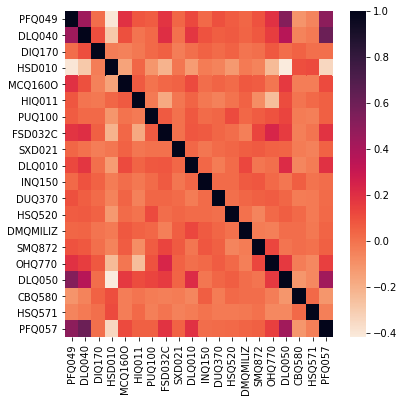

In [97]:
ax=plt.subplots(figsize=(6,6))
corr=X_final.corr()
sns.heatmap(corr, cmap=sns.cm.rocket_r)

In [77]:
#get highly correlated pairs, ranked by absolute correlation values 
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

In [78]:
get_top_abs_correlations(X_final, 10)

DLQ040  PFQ057    0.610007
PFQ049  DLQ050    0.526456
        PFQ057    0.497671
        DLQ040    0.444378
DLQ050  PFQ057    0.431400
HSD010  DLQ050    0.417874
PFQ049  HSD010    0.397053
DLQ040  DLQ050    0.359252
HSD010  PFQ057    0.343616
DLQ040  HSD010    0.286647
dtype: float64

### Narrowed down to 20 predictors; some of them are correlated but we can drop later.

In [79]:
X_final.shape

(3060, 20)

note: 
delete general health duplicate 


# 4. Shortlist promising models 

In [80]:
#final dataset (after balancing and feature selection)
train_X, valid_X, train_y, valid_y = train_test_split(X_final, y_final, test_size=0.4, random_state=42, stratify=y)
print('Training_X: ', train_X.shape)
print('Validation_X: ', valid_X.shape)
print('Training_y: ', train_y.shape)
print('Validation_y: ', valid_y.shape)

Training_X:  (1836, 20)
Validation_X:  (1224, 20)
Training_y:  (1836, 1)
Validation_y:  (1224, 1)


## 4.1 Baseline model: logistic regression 

In [81]:
logit=LogisticRegression()
logit.fit(train_X, train_y)

/Users/beiw/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


LogisticRegression()

In [82]:
coef= logit.coef_
coef= coef.flatten()
columns= train_X.columns
df = pd.DataFrame({'feature': columns, 
                   'coefficients': coef})
df = df.sort_values('coefficients', ascending=False)
df.columns=['variable', 'coefficients']
df['variable'] = df['variable'].apply(lambda x: x.upper())
df = pd.merge(left=df, right=cbook, left_on='variable', right_on='variable', how='left')

In [83]:
df

,variable,coefficients,label
0,HSD010,0.916561,General health condition
1,DMQMILIZ,0.411408,Served active duty in US Armed Forces
2,DIQ170,0.291755,Ever told have health risk for diabetes
3,SXD021,0.247878,"Ever had vaginal, anal, or oral sex"
4,MCQ160O,0.212367,Ever told you had COPD?
5,HIQ011,0.167882,Covered by health insurance
6,CBQ580,-0.124723,Saw nutrition info on restaurant menu
7,DLQ010,-0.229625,Have serious difficulty hearing?
8,SMQ872,-0.245834,Last 7-d someone smoked in car?
9,DLQ050,-0.256699,Have serious difficulty walking ?


In [86]:
from sklearn.model_selection import KFold, cross_val_score
from numpy import mean
from numpy import std
#cross-validation 
cv = KFold(n_splits=10, random_state=1, shuffle=True)
# evaluate model
scores = cross_val_score(logit, train_X,train_y, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

TypeError: estimator should be an estimator implementing 'fit' method, <statsmodels.discrete.discrete_model.BinaryResultsWrapper object at 0x7facad4c7b20> was passed

In [87]:
import statsmodels.api as sm
logit= sm.Logit(train_y, train_X).fit()
logit.summary()

Optimization terminated successfully.
         Current function value: 0.417333
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                mod_dep   No. Observations:                 1836
Model:                          Logit   Df Residuals:                     1816
Method:                           MLE   Df Model:                           19
Date:                Tue, 30 Nov 2021   Pseudo R-squ.:                  0.3443
Time:                        20:41:55   Log-Likelihood:                -766.22
converged:                       True   LL-Null:                       -1168.6
Covariance Type:            nonrobust   LLR p-value:                2.019e-158
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
PFQ049        -0.9349      0.175     -5.353      0.000      -1.277      -0.593
DLQ040        -1.6194      0.191     -8.475      0.000      -1.994      -1.245
DIQ170         0.4601      0.199      2.309      0.021       0.070       0.851
HSD010         1.0172      0.084     12.087      0.000       0.852       1.182
MCQ160O        0.7479      0.314      2.378      0.017       0.132       1.364
HIQ011         0.2726      0.166      1.646      0.100      -0.052       0.597
PUQ100        -0.4977      0.179     -2.776      0.006      -0.849      -0.146
FSD032C       -0.4202      0.107     -3.924      0.000      -0.630      -0.210
SXD021         0.5433      0.321      1.692      0.091      -0.086       1.173
DLQ010        -0.0574      0.239     -0.241      0.810      -0.525       0.410
INQ150        -0.2686      0.191     -1.408      0.159      -0.643       0.105
DUQ370         0.1992      0.373      0.534      0.593      -0.532       0.930
HSQ520        -0.4262      0.267     -1.598      0.110      -0.949       0.096
DMQMILIZ       0.7361      0.278      2.649      0.008       0.191       1.281
SMQ872        -0.1825      0.171     -1.069      0.285      -0.517       0.152
OHQ770        -0.4548      0.149     -3.052      0.002      -0.747      -0.163
DLQ050        -0.1761      0.184     -0.956      0.339      -0.537       0.185
CBQ580        -0.0320      0.163     -0.196      0.844      -0.352       0.288
HSQ571         0.2220      0.367      0.605      0.545      -0.497       0.941
PFQ057        -0.1935      0.216     -0.897      0.370      -0.616       0.229
==============================================================================
"""

note: add p values

## Cross-validation steps
https://machinelearningmastery.com/how-to-configure-k-fold-cross-validation/
cross-validation steps: first 3 steps are done using the training set; the test set will be held out till the end
1. training dataset is used to train a few candidate models 
2. validation dataset is used to evaluate the candidate models
3. one of the candidates is chosen
4. the chosen model is trained with a new training dataset
5. the trained model is evaluated with the test dataset

## 4.2 Decision tree classifier

In [88]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,RandomizedSearchCV 

param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': list(range(2,10)), 
    'min_samples_split': list(range(2,6))
}

gridSearch = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, 
                          n_jobs=-1)
gridSearch.fit(train_X, train_y)
print('initial score: ', gridSearch.best_score_)
print('parameters: ', gridSearch.best_params_)

bestClassTree = gridSearch.best_estimator_

initial score:  0.9063173794574103
parameters:  {'criterion': 'gini', 'max_depth': 7, 'min_samples_split': 5, 'splitter': 'best'}


In [89]:
#cross-validation using training set
cv = KFold(n_splits=10, random_state=1, shuffle=True)
# evaluate model
scores = cross_val_score(bestClassTree, train_X,train_y, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.892 (0.020)


## 4.3 Nearest neighbor

In [90]:
from sklearn.neighbors import NearestNeighbors

param_grid = {
    'n_neighbors': list(range(2,7)),
    'radius': [1, 1.2, 1.5, 2],
    'leaf_size': [25,30, 35] 
}

gridSearch = GridSearchCV(NearestNeighbors(), param_grid, cv=5, 
                          n_jobs=-1)
gridSearch.fit(train_X, train_y)
print('initial score: ', gridSearch.best_score_)
print('parameters: ', gridSearch.best_params_)

bestClassTree = gridSearch.best_estimator_

TypeError: If no scoring is specified, the estimator passed should have a 'score' method. The estimator NearestNeighbors() does not.

## 4.4 SMV classification

In [91]:
from sklearn.svm import LinearSVC
from scipy.stats import uniform

param_grid = {
    'penalty': ['l1', 'l2'],
    'loss': ['hinge', 'squared_hinge'],
    'C': [1, 1.2, 1.5, 2]
}

gridSearch = GridSearchCV(LinearSVC(random_state=42), param_grid, cv=5, 
                          n_jobs=-1)
gridSearch.fit(train_X, train_y)
print('initial score: ', gridSearch.best_score_)
print('parameters: ', gridSearch.best_params_)

bestClassTree = gridSearch.best_estimator_

initial score:  0.8142814832365832
parameters:  {'C': 2, 'loss': 'squared_hinge', 'penalty': 'l2'}


/Users/beiw/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.81046973        nan 0.81156113        nan 0.80883633
        nan 0.81101617        nan 0.81156113        nan 0.81101617
        nan 0.81046973        nan 0.81428148]
  warnings.warn(
/Users/beiw/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/beiw/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [92]:
#cross-validation using training set
cv = KFold(n_splits=10, random_state=1, shuffle=True)
# evaluate model
scores = cross_val_score(bestClassTree, train_X,train_y, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.813 (0.026)


## 4.5 ensemble: random forest classificaion

In [93]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,RandomizedSearchCV 

param_grid = {
    'max_leaf_nodes': list(range(2, 100)),
    'min_samples_split': [4,5,7,9]
}
gridSearch = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, 
                          n_jobs=-1)
gridSearch.fit(train_X, train_y)
print('initial score: ', gridSearch.best_score_)
print('parameters: ', gridSearch.best_params_)

bestClassTree = gridSearch.best_estimator_

/Users/beiw/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:880: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


initial score:  0.912856888994195
parameters:  {'max_leaf_nodes': 87, 'min_samples_split': 7}


In [94]:
#cross-validation using training set
cv = KFold(n_splits=10, random_state=1, shuffle=True)
# evaluate model
scores = cross_val_score(bestClassTree, train_X,train_y, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.908 (0.020)


In [96]:
# this looks like the best one so far, evaludate accuracy in test set 
classificationSummary(valid_y, bestClassTree.predict(valid_X))

Confusion Matrix (Accuracy 0.9077)

       Prediction
Actual   0   1
     0 779  37
     1  76 332


next steps: 
1.classification tree 
2.

## 4.6 ensemble: boosting/bagging 